# MMP Policy Evaluation: Facility-Level Analysis

### What can we learn about the effectiveness of MMP through cross-facility comparison?

<i> Maggie Hilderbran, Ryan Treves

**TO DO:**

-

##### 0. Set-up.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yaml
from pathlib import Path
from IPython.display import clear_output
import sys

# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# turn off warning messages
warnings.filterwarnings('ignore')

In [2]:
# import & use utility functions sitting in 'main.py'
sys.path.append('../../../ca_mmp')
from policy_eval import main
from policy_eval import scrape_facility_reports as sr

##### 1. Reading in and preprocessing data.

In [3]:
print('Reading in configuration and data files.')
clear_output(wait=True)

# read in configuration file
print('Reading in configuration file.')
with open(Path().resolve().parent / 'config.yml', 'r') as file:
    configs = yaml.safe_load(file)
data_path = Path(configs['CIWQS_data_path'])
clear_output(wait=True)

# read in data
print('Reading violations file.')
violations = pd.read_excel(data_path / 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str})
clear_output(wait=True)
print('Reading enforcements file.')
enforcements = pd.read_csv(data_path / 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID', 'NPDES # CA#': 'NPDES# CA#'}, inplace=True)
clear_output(wait=True)
print('Reading enforcements-violations crosswalk file.')
enf_viol_links = pd.read_excel(data_path / 'Copy-of-RegMeasViolations.xlsx', dtype={'Violation ID': object})
clear_output(wait=True)
print('Reading DMR values file.')
dmr_values = pd.read_csv(data_path / 'CA_dmrs_20221123.csv',
                         parse_dates=['monitoring_period_end_date'],
                         date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
clear_output(wait=True)

Reading DMR values file.


In [4]:
# get links between FACILITY_IDs and NPDES permit IDs
facility_npdes_links_enforcements = enforcements[['FACILITY_ID', 'NPDES# CA#']]
facility_npdes_links_violations = violations[['FACILITY_ID', 'NPDES# CA#']]

facility_npdes_links = pd.concat([facility_npdes_links_enforcements, facility_npdes_links_violations]).drop_duplicates().dropna(subset=['NPDES# CA#'])

facility_npdes_links.head()

,FACILITY_ID,NPDES# CA#
5,252750,CA0022748
11,268960,CA0022888
13,255703,CA0022764
78,225055,CA0023078
83,248195,CA0005622


In [5]:
print('Cleaning enforcements data.')

# filter out enforcements with no MMP violations
enforcements_mmp = main.clean_enforcements(enforcements, mmp_only=True)
clear_output(wait=True)
del enforcements

Cleaning enforcements data.


In [6]:
print('Cleaning violations data.')

# filter violations table to MMP non-exempt, effluent violations
violations_mmp = main.clean_violations(violations, mmp_only=True, effluent_only=True)
clear_output(wait=True)
del violations

Cleaning violations data.


In [7]:
# subset to only valid MMP-related EPLs and estimate EPL issuance dates (NB: 'valid' = status is not 'Withdrawn' or 'Draft')
print('Identifying valid, MMP-related EPLs and estimating issuance dates.\n')
enforcements_mmp_epl = main.get_epls(enforcements_mmp, valid_only=False)  # estimating using 'EFFECTIVE DATE.1' as a backup
clear_output(wait=True)

Identifying valid, MMP-related EPLs and estimating issuance dates.



In [8]:
# link enforcements and violations data (result: table of all violations that are linked to an MMP EPL enforcement action)
print('Linking valid, MMP-related EPLs to MMP-eligible, effluent violations.')
violations_mmp_epl = enf_viol_links.merge(enforcements_mmp_epl, how='right', left_on='Reg Measure ID',
                                          right_on='ENFORCEMENT ID (EID)')
violations_mmp_epl.drop('Reg Measure ID', axis=1, inplace=True)
violations_mmp_epl.rename(columns={'Violation ID': 'VIOLATION ID (VID)'}, inplace=True)

violations_mmp_epl_merged = violations_mmp_epl.merge(violations_mmp, on=['VIOLATION ID (VID)'], how='inner')
clear_output(wait=True)

Linking valid, MMP-related EPLs to MMP-eligible, effluent violations.


##### 2. Defining potential treatment & comparison groups.

In [9]:
# creating facilities table
facilities = pd.DataFrame()
facilities['FACILITY_ID'] = violations_mmp['FACILITY_ID'].unique()

**Question #1: Did a facility receive an EPL in the '08-09 enforcement push?**

In [10]:
print('Identifying facilities that did and did NOT receive EPLs in \'08-09 push.')
facilities_epl_treat = enforcements_mmp_epl[
                                            (enforcements_mmp_epl['estimated_epl_date'] >= pd.to_datetime(main.TREATMENT_START_DATE)) &
                                            (enforcements_mmp_epl['estimated_epl_date'] <= pd.to_datetime(main.TREATMENT_END_DATE)) &
                                            (enforcements_mmp_epl['STATUS.1'].apply(lambda x: x not in ['Withdrawn', 'Draft']))
                                            ]
facilities_epl_treat = facilities_epl_treat['FACILITY_ID'].unique()

# identify facilities which received EPLs in 08-09 which were later withdrawn
facilities_epl_withdrawn = enforcements_mmp_epl[
                                            (enforcements_mmp_epl['estimated_epl_date'] >= pd.to_datetime(main.TREATMENT_START_DATE)) &
                                            (enforcements_mmp_epl['estimated_epl_date'] <= pd.to_datetime(main.TREATMENT_END_DATE)) &
                                            (enforcements_mmp_epl['STATUS.1']=='Withdrawn')
                                            ]
facilities_epl_withdrawn = facilities_epl_withdrawn['FACILITY_ID'].unique()

facilities['epl_treat_flag'] = facilities['FACILITY_ID'].isin(facilities_epl_treat)
clear_output(wait=True)

Identifying facilities that did and did NOT receive EPLs in '08-09 push.


**Question #2: Was MMP consistently enforced for a facility prior to the '08-09 push?**

Here, we consider two different interpretations of 'prior to the '08-09 push': a) prior to treatment and b) during pretreatment.

We calculate the enforcement rate, borrowing Ryan's method (see `sample_identification.ipynb`).
Due to the difficulty of accounting for instances where a single violation is linked to multiple enforcement actions, here we define enforcement rate as the sum of the number of  MMP violations linked to pre-push enforcements(`enforcements_mmp_prior_violcount`, `enforcements_mmp_pretreat_violcount`) divided by the number of pre-push MMP violations (`violations_mmp_prior_count`, `violations_mmp_pretreat_count`). Thus, the enforcement rate can exceed 1 when a violation is enforced multiple times.

In [11]:
print('Identifying facilities with and without consistent enforcement of MMP program a) prior to treatment and b) during pretreatment.')
print('     (\'Consistent\' enforcement = enforcement rate of',main.HIGH_ENFORCEMENT_RATE_THRESHOLD,'or greater.)')


# get count of MMP violations linked to prior enforcements for each facility
enforcements_mmp_prior_violcounts = enforcements_mmp[enforcements_mmp['EFFECTIVE DATE.1'] < pd.to_datetime(main.TREATMENT_START_DATE)
                                                     ].groupby('FACILITY_ID', as_index=False).sum()[['FACILITY_ID',
                                                                                                        'TOTAL MMP VIOLATIONS #']]
enforcements_mmp_prior_violcounts.rename(columns={'TOTAL MMP VIOLATIONS #': 'enforcements_mmp_prior_violcount'},
                                         inplace=True)

# get count of ALL MMP violations prior to treatment
facilities = facilities.merge(enforcements_mmp_prior_violcounts, how='left', on='FACILITY_ID')

violations_mmp_prior = violations_mmp[violations_mmp['OCCURRED ON'] < pd.to_datetime(main.TREATMENT_START_DATE)
                                      ].groupby('FACILITY_ID', as_index=False).nunique()[['FACILITY_ID',
                                                                                             'VIOLATION ID (VID)']]
violations_mmp_prior.rename(columns={'VIOLATION ID (VID)': 'violations_mmp_prior_count'},
                            inplace=True)
facilities = facilities.merge(violations_mmp_prior, how='left', on='FACILITY_ID')

# calculate enforcement rate during period prior to treatment
facilities['enforcement_prior_rate'] = facilities['enforcements_mmp_prior_violcount'] / \
                                       facilities['violations_mmp_prior_count']


# get count of MMP violations linked to pretreatment enforcements for each facility
enforcements_mmp_pretreat_violcounts = enforcements_mmp[(enforcements_mmp['EFFECTIVE DATE.1'] < pd.to_datetime(main.TREATMENT_START_DATE)) &
                                                        (enforcements_mmp['EFFECTIVE DATE.1'] >= pd.to_datetime(main.PRETREATMENT_START_DATE))
                                                        ].groupby('FACILITY_ID', as_index=False).sum()[['FACILITY_ID',
                                                                                                        'TOTAL MMP VIOLATIONS #']]
enforcements_mmp_pretreat_violcounts.rename(columns={'TOTAL MMP VIOLATIONS #': 'enforcements_mmp_pretreat_violcount'},
                                            inplace=True)

# get count of ALL MMP violations during pretreatment period
facilities = facilities.merge(enforcements_mmp_pretreat_violcounts, how='left', on='FACILITY_ID')

violations_mmp_pretreat = violations_mmp[(violations_mmp['OCCURRED ON'] < pd.to_datetime(main.TREATMENT_START_DATE)) &
                                         (violations_mmp['OCCURRED ON'] >= pd.to_datetime(main.PRETREATMENT_START_DATE))
                                         ].groupby('FACILITY_ID', as_index=False).nunique()[['FACILITY_ID',
                                                                                             'VIOLATION ID (VID)']]
violations_mmp_pretreat.rename(columns={'VIOLATION ID (VID)': 'violations_mmp_pretreat_count'},
                               inplace=True)
facilities = facilities.merge(violations_mmp_pretreat, how='left', on='FACILITY_ID')

# calculate enforcement rate during pretreatment period
facilities['enforcement_pretreat_rate'] = facilities['enforcements_mmp_pretreat_violcount'] / \
                                          facilities['violations_mmp_pretreat_count']


# identify facilities with 'consistent' enforcement
facilities['enforcement_prior_flag'] = facilities['enforcement_prior_rate'] >= main.HIGH_ENFORCEMENT_RATE_THRESHOLD
facilities['enforcement_pretreat_flag'] = facilities['enforcement_pretreat_rate'] >= main.HIGH_ENFORCEMENT_RATE_THRESHOLD


# replace NaN with 0
facilities.fillna(0, inplace=True)
facilities.head()

Identifying facilities with and without consistent enforcement of MMP program a) prior to treatment and b) during pretreatment.
     ('Consistent' enforcement = enforcement rate of 0.75 or greater.)


,FACILITY_ID,epl_treat_flag,enforcements_mmp_prior_violcount,violations_mmp_prior_count,enforcement_prior_rate,enforcements_mmp_pretreat_violcount,violations_mmp_pretreat_count,enforcement_pretreat_rate,enforcement_prior_flag,enforcement_pretreat_flag
0,259171,False,278.0,180.0,1.544444,0.0,15.0,0.0,True,False
1,261701,True,0.0,8.0,0.000000,0.0,4.0,0.0,False,False
2,233276,False,0.0,2.0,0.000000,0.0,0.0,0.0,False,False
3,236817,False,0.0,3.0,0.000000,0.0,2.0,0.0,False,False
4,248886,False,19.0,23.0,0.826087,0.0,0.0,0.0,True,False


In [12]:
# treatment facilities need to have a) received an EPL during our treatment period
# and b) had a low MMP enforcement rate prior to the treatment period
treatment_facilities = list(facilities[(facilities['epl_treat_flag']) &
                                  (facilities['enforcement_prior_rate'] <= main.LOW_ENFORCEMENT_RATE_THRESHOLD)]['FACILITY_ID'])
# comparison facilities need to have a) NOT received an EPL during the treatment period
# and b) had a high MMP enforcement rate prior to the treatment period
comparison_facilities = list(facilities[~(facilities['epl_treat_flag']) &
                                  (facilities['enforcement_prior_flag']) &
                                  (facilities['FACILITY_ID'].apply(lambda x: x not in facilities_epl_withdrawn))]['FACILITY_ID'])

# set aside treatment and comparison violations
treatment_violations = violations_mmp[violations_mmp['FACILITY_ID'].apply(lambda x: x in treatment_facilities)]
comparison_violations = violations_mmp[violations_mmp['FACILITY_ID'].apply(lambda x: x in comparison_facilities)]

**Question #3: Did a facility have an active NPDES permit throughout our analysis period?**

In [13]:
# get Facility At-A-Glance report for each facility (via 'place_ids', which are our 'FACILITY_ID' values)
# OPTION 1: scrape from web
place_ids = [*treatment_facilities, *comparison_facilities]
print(f'Scraping Facility At-A-Glance data for {len(place_ids)} facilities.')
facility_reports = sr.scrape_facility_reports(place_ids, verbose=True)
facility_reports.to_csv('facility_reports.csv')
# OPTION 2: read CSV of already-scraped reports
'''facility_reports = pd.read_csv('facility_reports.csv',
                               dtype={'FACILITY ID': object},
                               parse_dates=['Effective Date', 'Expiration Date'],
                               date_parser=lambda x: pd.to_datetime(x, errors='coerce'))'''
facility_reports.head()

,Reg Measure ID,Reg Measure Type,Region,Program,Order No.,WDID,Effective Date,Expiration Date,Status,Amended?,FACILITY_ID
0,349224,NPDES Permit,4,NPDNONMUNIPRCS,R4-2008-0024,4B191035001,2008-05-31,2013-04-10,Historical,N,261701
0,131114,NPDES Permit,4,NPDESWW,R4-2001-0152,4B191035001,2001-11-04,2007-09-10,Historical,N,261701
0,135525,NPDES Permit,4,NPDESWW,95-010,4B191035001,1995-01-23,1999-12-10,Historical,N,261701
0,133874,NPDES Permit,4,NPDESWW,87-080,4B191035001,1987-06-22,1992-06-10,Historical,N,261701
0,134882,NPDES Permit,4,NPDESWW,82-047,4B191035001,1982-07-26,1987-07-10,Historical,N,261701


First, scrape historical permit data from CIWQS for our treatment and comparison groups.

In [14]:
treatment_fac_reports = sr.scrape_facility_reports(treatment_facilities)
comparison_fac_reports = sr.scrape_facility_reports(comparison_facilities)

In [15]:
# get estimated facility entrance/exit dates into/from population
treatment_violations = main.get_facility_entrance_exit(facility_reports[facility_reports['FACILITY_ID'].apply(lambda x: x in treatment_facilities)], treatment_violations)
comparison_violations = main.get_facility_entrance_exit(facility_reports[facility_reports['FACILITY_ID'].apply(lambda x: x in comparison_facilities)], comparison_violations)

For stable group composition, we need to condition on having an active NPDES permit during the analysis period. Here, we set it to 2004-2012.

In [16]:
treatment_violations = treatment_violations[
                                # Enter the population by 2004
                                (treatment_violations['estimated_entrance_date'] <= pd.to_datetime('2004-01-01')) &
                                # Do not exit the population before 2013
                                ~(treatment_violations['estimated_exit_date'] <= pd.to_datetime('2012-12-31'))]
comparison_violations = comparison_violations[
                                # Enter the population by 2004
                                (comparison_violations['estimated_entrance_date'] <= pd.to_datetime('2004-01-01')) &
                                # Do not exit the population before 2013
                                ~(comparison_violations['estimated_exit_date'] <= pd.to_datetime('2012-12-31'))]

**Our final sample:**

In [17]:
# Redefine sets of treatment and control facilities
treatment_facilities = list(treatment_violations['FACILITY_ID'].unique())
comparison_facilities = list(comparison_violations['FACILITY_ID'].unique())
print(f'Facilities in treatment group: {len(treatment_facilities)}.')
print(f'Facilities in comparison group: {len(comparison_facilities)}.')

Facilities in treatment group: 46.
Facilities in comparison group: 96.


##### 3. Prepare data for DiD analysis.

In [18]:
timescale = 'yearly'

# preprocess violations data for regression
violations_to_analyze_facility_level = main.regression_preprocess_facility(treatment_violations, comparison_violations, violations_mmp, timescale=timescale)
# link facilities to NPDES permit IDs
violations_to_analyze_facility_level = violations_to_analyze_facility_level.merge(facility_npdes_links, how='left', on='FACILITY_ID')

violations_to_analyze_facility_level.head()

,FACILITY_ID,violation_period,n_violations,treatment,violation_status,Region,post,NPDES# CA#
0,203650,2000,0.0,1,0,4,0,CAG834001
1,203650,2001,0.0,1,0,4,0,CAG834001
2,203650,2002,0.0,1,0,4,0,CAG834001
3,203650,2003,0.0,1,0,4,0,CAG834001
4,203650,2004,0.0,1,0,4,0,CAG834001


In [19]:
# get count of reported DMR values per time period (i.e., "opportunities to violate")
reported_dmr_values_counts = main.get_reported_values(dmr_values, timescale=timescale)
reported_dmr_values_counts.head()

,npdes_permit_id,monitoring_period_end,n_values_permit_period,mean_n_values_permit
0,CA0000035,1993,24,14.8
1,CA0000035,1994,24,14.8
2,CA0000035,1995,3,14.8
3,CA0000035,1996,18,14.8
4,CA0000035,1997,5,14.8


In [20]:
mean_reported_vals = reported_dmr_values_counts[['npdes_permit_id', 'mean_n_values_permit']].drop_duplicates()

In [21]:
violations_to_analyze_facility_level = violations_to_analyze_facility_level.merge(reported_dmr_values_counts.loc[:, reported_dmr_values_counts.columns!='mean_n_values_permit'],
                                                                                  how='left',
                                                                                  left_on=['NPDES# CA#', 'violation_period'],
                                                                                  right_on=['npdes_permit_id', 'monitoring_period_end'])
violations_to_analyze_facility_level.head()

,FACILITY_ID,violation_period,n_violations,treatment,violation_status,Region,post,NPDES# CA#,npdes_permit_id,monitoring_period_end,n_values_permit_period
0,203650,2000,0.0,1,0,4,0,CAG834001,NaN,NaN,NaN
1,203650,2001,0.0,1,0,4,0,CAG834001,NaN,NaN,NaN
2,203650,2002,0.0,1,0,4,0,CAG834001,NaN,NaN,NaN
3,203650,2003,0.0,1,0,4,0,CAG834001,NaN,NaN,NaN
4,203650,2004,0.0,1,0,4,0,CAG834001,NaN,NaN,NaN


In [22]:
violations_to_analyze_facility_level = violations_to_analyze_facility_level.merge(mean_reported_vals, how='left',
                                                                                  left_on='NPDES# CA#', right_on='npdes_permit_id')

In [23]:
violations_to_analyze_facility_level['n_values_permit_period'] = violations_to_analyze_facility_level.n_values_permit_period.combine_first(violations_to_analyze_facility_level.mean_n_values_permit)
violations_to_analyze_facility_level.drop(columns=['npdes_permit_id_x','monitoring_period_end','npdes_permit_id_y'], inplace=True)
violations_to_analyze_facility_level.head()

,FACILITY_ID,violation_period,n_violations,treatment,violation_status,Region,post,NPDES# CA#,n_values_permit_period,mean_n_values_permit
0,203650,2000,0.0,1,0,4,0,CAG834001,NaN,NaN
1,203650,2001,0.0,1,0,4,0,CAG834001,NaN,NaN
2,203650,2002,0.0,1,0,4,0,CAG834001,NaN,NaN
3,203650,2003,0.0,1,0,4,0,CAG834001,NaN,NaN
4,203650,2004,0.0,1,0,4,0,CAG834001,NaN,NaN


Let's check the links between the violation/enforcement data and the DMR data.

In [24]:
# number of unique facility IDs in our sample
violations_to_analyze_facility_level['FACILITY_ID'].nunique()

142

In [25]:
# of unique permit IDs in our sample
len(violations_to_analyze_facility_level['NPDES# CA#'].unique())

136

Our number of facilities and number of permits are not the same. Why?

In [26]:
# unique facility-permit pairs in our sample
violations_to_analyze_facility_level_facilities_npdes = violations_to_analyze_facility_level[['FACILITY_ID', 'NPDES# CA#']].drop_duplicates()
len(violations_to_analyze_facility_level_facilities_npdes)

156

In [27]:
# get facilities w/multiple NPDES permit IDs in the violations data

# find facility IDs that show up multiple times in the facility-permit pairs
facilities_multiple_npdes = list(violations_to_analyze_facility_level_facilities_npdes[violations_to_analyze_facility_level_facilities_npdes.duplicated(subset=['FACILITY_ID'])]['FACILITY_ID'])
# count of unique facility IDs in this subset
len(set(facilities_multiple_npdes))

14

In [28]:
# count those facilities and their associated permit IDs
len(violations_to_analyze_facility_level_facilities_npdes[violations_to_analyze_facility_level_facilities_npdes['FACILITY_ID'].apply(lambda x: x in facilities_multiple_npdes)].sort_values(by='FACILITY_ID'))

28

In [29]:
# get permits with multiple facilities in the violations data

# find NPDES IDs that show up multiple times in the facility-permit pairs
npdes_multiple_facilities = list(violations_to_analyze_facility_level_facilities_npdes[violations_to_analyze_facility_level_facilities_npdes.duplicated(subset=['NPDES# CA#'])]['NPDES# CA#'])
# count of unique NPDES IDs in this subset
len(set(npdes_multiple_facilities))

6

In [30]:
# count those permits and their associated facility IDs
len(violations_to_analyze_facility_level_facilities_npdes[violations_to_analyze_facility_level_facilities_npdes['NPDES# CA#'].apply(lambda x: x in npdes_multiple_facilities)].sort_values(by='NPDES# CA#'))

26

In [31]:
# check how often we have NPDES permit IDs for facilities

# facilities for which we do have a NPDES ID
facilities_npdes = violations_to_analyze_facility_level[~violations_to_analyze_facility_level['NPDES# CA#'].isnull()]['FACILITY_ID']
facilities_npdes = list(facilities_npdes.unique())
# how many facilities is this?
len(facilities_npdes)

142

In [32]:
# is this all of our facilities?
set(facilities_npdes) == set(treatment_facilities + comparison_facilities)

True

In [33]:
# check how much DMR data we have

# facilities for which we do have DMR data
facilities_dmr = violations_to_analyze_facility_level[~violations_to_analyze_facility_level['n_values_permit_period'].isnull()]['FACILITY_ID']
facilities_dmr = list(facilities_dmr.unique())
# how many facilities is this?
len(facilities_dmr)

102

In [34]:
# facilities w/no DMR data
len(violations_to_analyze_facility_level[violations_to_analyze_facility_level['FACILITY_ID'].apply(lambda x: x not in facilities_dmr)][['FACILITY_ID']].drop_duplicates().sort_values(by='FACILITY_ID'))

40

In [35]:
'''# check facilities with pre-2016 data
if timescale == 'yearly':
    facilities_pre_2016 = violations_to_analyze_facility_level[violations_to_analyze_facility_level['violation_period'] < 2016]
elif timescale == 'quarterly':
    facilities_pre_2016 = violations_to_analyze_facility_level[violations_to_analyze_facility_level['violation_period'] < 184]  #Q1 of 2016
facilities_pre_2016 = facilities_pre_2016[~facilities_pre_2016['npdes_permit_id'].isnull()]['FACILITY_ID']
facilities_pre_2016 = list(facilities_pre_2016.unique())
# how many facilities is this?
len(facilities_pre_2016)''';

In [36]:
# write to disk for later use
violations_to_analyze_facility_level.to_csv(f'violations_to_analyze_facility_level_{timescale}.csv')

For DiD regression analysis, see `facility_level_analysis.Rmd`.

##### 4. Checking assumptions for difference-in-differences (DiD) method.

**Assumption #1: Treatment and comparison groups have no differences that would confound compliance responses to treatment.**

In [37]:
comparison_columns = ['VIOLATED FACILITY REGION', 'PROGRAM', 'MAJOR-MINOR']

group_results = pd.DataFrame()
for column in comparison_columns:
    group_results = pd.concat([group_results, main.compare_composition(
        comparison_violations.drop_duplicates('FACILITY_ID'),
        treatment_violations.drop_duplicates('FACILITY_ID'),
        column, top_n=10)])
group_results.sort_values(by='diff', ascending=False, inplace=True)
group_results

,Value,Comparison,Treatment,diff,p_value (fishers_exact_test)
VIOLATED FACILITY REGION,4,0.12,0.83,0.71,6.168088e-17
PROGRAM,NPDNONMUNIPRCS,0.06,0.54,0.48,3.654013e-10
MAJOR-MINOR,Major,0.61,0.26,0.35,2.883992e-04
PROGRAM,NPDMUNILRG,0.56,0.22,0.35,1.305124e-04
MAJOR-MINOR,Minor,0.39,0.74,0.35,1.362941e-04
PROGRAM,NPDMUNIOTH,0.26,0.02,0.24,3.229296e-04
VIOLATED FACILITY REGION,5S,0.19,0.00,0.19,7.431681e-04
VIOLATED FACILITY REGION,1,0.13,0.00,0.13,9.216827e-03
VIOLATED FACILITY REGION,8,0.11,0.00,0.11,3.045232e-02
PROGRAM,NPDESWW,0.04,0.15,0.11,3.873002e-02


**Assumption #2: Treatment and comparison groups don’t differ in terms of levels of compliance pre-treatment.**

How many violations do facilities have?

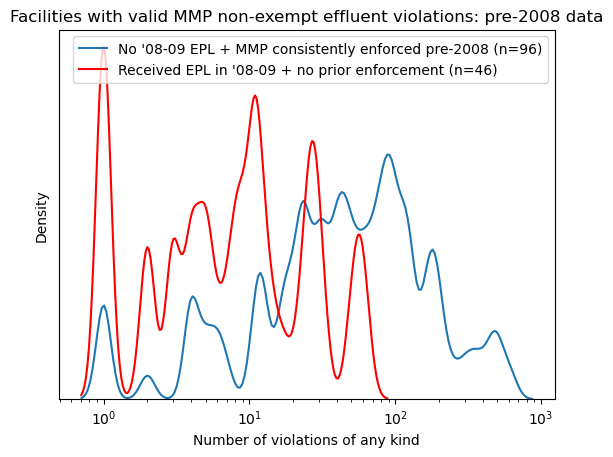

In [38]:
plt.style.use('default')
sns.kdeplot(
    data=comparison_violations[comparison_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')].groupby(
        'FACILITY_ID').nunique(),
    x='VIOLATION ID (VID)', bw_adjust=0.2, log_scale=True,
    label=f'No \'08-09 EPL + MMP consistently enforced pre-2008 (n={len(comparison_facilities)})');
sns.kdeplot(
    data=treatment_violations[(treatment_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01'))].groupby(
        'FACILITY_ID').nunique(), x='VIOLATION ID (VID)', bw_adjust=0.2,
    log_scale=True, c='red', label=f'Received EPL in \'08-09 + no prior enforcement (n={len(treatment_facilities)})');
plt.xlabel('Number of violations of any kind')
plt.yticks([])
plt.title('Facilities with valid MMP non-exempt effluent violations: pre-2008 data')
plt.legend();

How frequently are facilities violating?

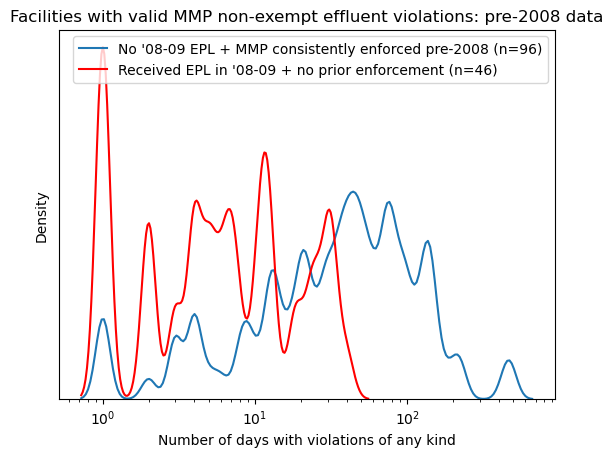

In [39]:
plt.style.use('default')
sns.kdeplot(
    data=comparison_violations[comparison_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')].groupby(
        'FACILITY_ID').agg(num_violation_days=pd.NamedAgg(column='OCCURRED ON', aggfunc=lambda x: x.nunique())), x='num_violation_days', log_scale=True, bw_adjust=0.2,
    label=f'No \'08-09 EPL + MMP consistently enforced pre-2008 (n={len(comparison_facilities)})');
sns.kdeplot(
    data=treatment_violations[(treatment_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01'))].groupby(
        'FACILITY_ID').agg(num_violation_days=pd.NamedAgg(column='OCCURRED ON', aggfunc=lambda x: x.nunique())), x='num_violation_days', log_scale=True, bw_adjust=0.2,
    c='red', label=f'Received EPL in \'08-09 + no prior enforcement (n={len(treatment_facilities)})')
plt.xlabel('Number of days with violations of any kind')
plt.yticks([])
plt.title('Facilities with valid MMP non-exempt effluent violations: pre-2008 data')
plt.legend();

What about with our binary outcome?

In [40]:
violations_to_analyze_facility_level_violation_status = violations_to_analyze_facility_level[(violations_to_analyze_facility_level['violation_period'] < 2008) & (violations_to_analyze_facility_level['violation_period'] >= 2004)]
violations_to_analyze_facility_level_violation_status = violations_to_analyze_facility_level_violation_status.drop(columns=['NPDES# CA#', 'n_values_permit_period', 'mean_n_values_permit']).drop_duplicates()
violations_to_analyze_facility_level_violation_status['num_violation_years'] = violations_to_analyze_facility_level_violation_status.groupby(
        'FACILITY_ID')['violation_status'].transform('sum')
violations_to_analyze_facility_level_violation_status = violations_to_analyze_facility_level_violation_status[['FACILITY_ID', 'treatment', 'Region', 'num_violation_years']].drop_duplicates()
violations_to_analyze_facility_level_violation_status.head()

,FACILITY_ID,treatment,Region,num_violation_years
4,203650,1,4,3
26,211482,1,4,4
48,212135,1,4,1
70,216832,1,4,1
92,217317,1,4,1


Text(0.5, 1.0, 'Facilities with valid MMP non-exempt effluent violations: pre-2008 data')

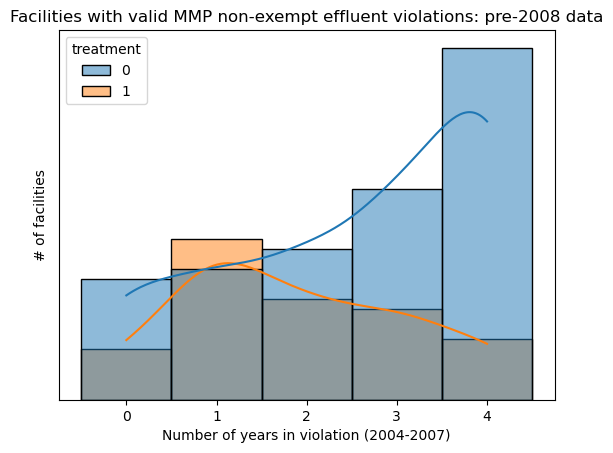

In [41]:
plt.style.use('default')
sns.histplot(
    violations_to_analyze_facility_level_violation_status, x='num_violation_years',
    hue='treatment',
    kde=True,
    discrete=True
    );
plt.xlabel('Number of years in violation (2004-2007)')
plt.ylabel('# of facilities')
plt.yticks([])
plt.title('Facilities with valid MMP non-exempt effluent violations: pre-2008 data')

What about with our violation count outcome?

In [42]:
violations_to_analyze_facility_level_n_violations = violations_to_analyze_facility_level[(violations_to_analyze_facility_level['violation_period'] < 2008) & (violations_to_analyze_facility_level['violation_period'] >= 2004)]
violations_to_analyze_facility_level_n_violations['prop_violated'] = violations_to_analyze_facility_level_n_violations.groupby(
        'FACILITY_ID')['n_violations'].transform('sum') / violations_to_analyze_facility_level_n_violations.groupby(
        'FACILITY_ID')['n_values_permit_period'].transform('sum')
violations_to_analyze_facility_level_n_violations = violations_to_analyze_facility_level_n_violations[['FACILITY_ID', 'treatment', 'Region', 'prop_violated']].drop_duplicates()
violations_to_analyze_facility_level_n_violations.head()

,FACILITY_ID,treatment,Region,prop_violated
4,203650,1,4,inf
26,211482,1,4,inf
48,212135,1,4,0.006297
70,216832,1,4,inf
92,217317,1,4,inf


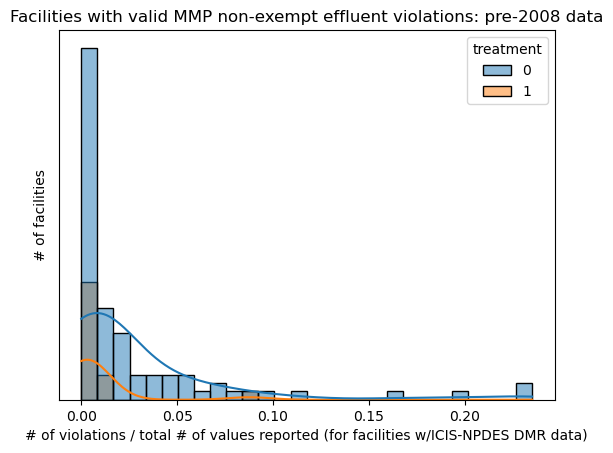

In [43]:
plt.style.use('default')
sns.histplot(
    violations_to_analyze_facility_level_n_violations[violations_to_analyze_facility_level_n_violations['prop_violated'] != np.inf], x='prop_violated',
    hue='treatment',
    kde=True,
    );
plt.xlabel('# of violations / total # of values reported (for facilities w/ICIS-NPDES DMR data)')
plt.ylabel('# of facilities')
plt.yticks([])
plt.title('Facilities with valid MMP non-exempt effluent violations: pre-2008 data');

Do pre-2008 violations in the two groups differ in terms of qualitative characteristics?

In [44]:
violation_results = pd.DataFrame()
for column in ['VIOLATION SUBTYPE', 'VIOLATION TYPE', 'MMP TYPE']:
    violation_results = pd.concat([violation_results, main.compare_composition(
        comparison_violations[comparison_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')],
        treatment_violations[treatment_violations['OCCURRED ON'] < pd.to_datetime('2008-07-01')], column)])
violation_results.sort_values(by='diff', ascending=False, inplace=True)
violation_results

,Value,Comparison,Treatment,diff,p_value (fishers_exact_test)
MMP TYPE,Chronic,0.65,0.39,0.26,5.305701e-73
MMP TYPE,Serious,0.35,0.61,0.26,9.276044e-01
VIOLATION SUBTYPE,CAT2,0.16,0.33,0.17,7.549156e-22
VIOLATION SUBTYPE,CAT1,0.45,0.35,0.10,1.129283e-06
VIOLATION SUBTYPE,OEV,0.37,0.27,0.10,3.961931e-07
VIOLATION TYPE,Effluent,1.00,1.00,0.00,1.000000e+00


**Assumption #3: Treatment group has a parallel compliance pre-trend with the comparison group.**

In [45]:
comparison_violations['Violation quarter'] = comparison_violations['OCCURRED ON'].dt.to_period('Q').astype(int)
treatment_violations['Violation quarter'] = treatment_violations['OCCURRED ON'].dt.to_period('Q').astype(int)

# Calculate number of violating facilities each quarter
to_plot_comparison = comparison_violations.groupby('Violation quarter', as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))
to_plot_treatment = treatment_violations.groupby('Violation quarter', as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))

# Calculate number of active facilities each quarter
to_plot_comparison['n_facilities_active'] = to_plot_comparison['Violation quarter'].apply(lambda x: len(
    # Facility has to have enrolled in NPDES on or before the quarter in question
    comparison_violations[(comparison_violations['estimated_entrance_quarter'] <= x) &
        # and NOT have a permit that has expired by the quarter in question
            (~(comparison_violations['estimated_exit_quarter'] <= x))].drop_duplicates('FACILITY_ID')))

# Same for treatment group
to_plot_treatment['n_facilities_active'] = to_plot_treatment['Violation quarter'].apply(lambda x: len(
    treatment_violations[(treatment_violations['estimated_entrance_quarter'] <= x) &
                (~(treatment_violations['estimated_exit_quarter'] <= x))].drop_duplicates('FACILITY_ID')))

# Divide violating # by active #
to_plot_comparison['Violation rate'] = to_plot_comparison['n_violating_facilities'] / to_plot_comparison[
    'n_facilities_active']
to_plot_treatment['Violation rate'] = to_plot_treatment['n_violating_facilities'] / to_plot_treatment[
    'n_facilities_active']

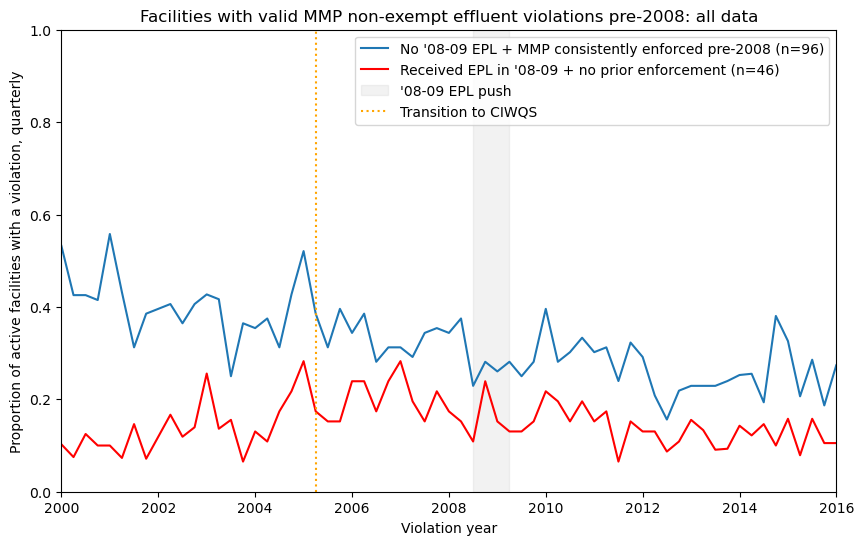

In [46]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(to_plot_comparison['Violation quarter'], to_plot_comparison['Violation rate'],
         label=f'No \'08-09 EPL + MMP consistently enforced pre-2008 (n={len(comparison_facilities)})');
plt.plot(to_plot_treatment['Violation quarter'], to_plot_treatment['Violation rate'],
         label=f'Received EPL in \'08-09 + no prior enforcement (n={len(treatment_facilities)})', color='red');

plt.fill_betweenx([0, 1], 154, 157, alpha=0.2, color='silver',
                  label='\'08-09 EPL push')
plt.axvline(x=141, linestyle=':', color='orange', label='Transition to CIWQS')
plt.ylabel('Proportion of active facilities with a violation, quarterly')
plt.ylim((0, 1))
plt.xlim((120, 184))
plt.xticks(list(range(120, 192, 8)), [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016])
plt.xlabel('Violation year')
plt.title('Facilities with valid MMP non-exempt effluent violations pre-2008: all data')
plt.legend();

In [47]:
comparison_violations['Violation year'] = comparison_violations['OCCURRED ON'].dt.year
treatment_violations['Violation year'] = treatment_violations['OCCURRED ON'].dt.year

# Calculate number of violating facilities each quarter
to_plot_comparison = comparison_violations.groupby('Violation year', as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))
to_plot_treatment = treatment_violations.groupby('Violation year', as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))

# Calculate number of active facilities each quarter
to_plot_comparison['n_facilities_active'] = to_plot_comparison['Violation year'].apply(lambda x: len(
    # Facility has to have enrolled in NPDES on or before the year in question
    comparison_violations[(comparison_violations['estimated_entrance_date'].dt.year <= x) &
        # and NOT have a permit that has expired before the year in question
            (~(comparison_violations['estimated_exit_date'].dt.year < x))].drop_duplicates('FACILITY_ID')))

# Same for treatment group
to_plot_treatment['n_facilities_active'] = to_plot_treatment['Violation year'].apply(lambda x: len(
    treatment_violations[(treatment_violations['estimated_entrance_date'].dt.year <= x) &
                (~(treatment_violations['estimated_exit_date'].dt.year < x))].drop_duplicates('FACILITY_ID')))

# Divide violating # by active #
to_plot_comparison['Violation rate'] = to_plot_comparison['n_violating_facilities'] / to_plot_comparison[
    'n_facilities_active']
to_plot_treatment['Violation rate'] = to_plot_treatment['n_violating_facilities'] / to_plot_treatment[
    'n_facilities_active']

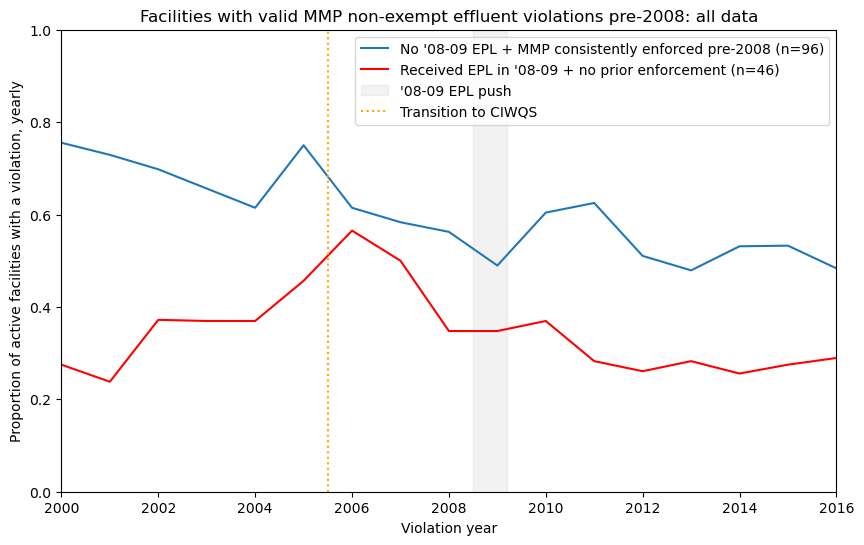

In [48]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(to_plot_comparison['Violation year'], to_plot_comparison['Violation rate'],
         label=f'No \'08-09 EPL + MMP consistently enforced pre-2008 (n={len(comparison_facilities)})');
plt.plot(to_plot_treatment['Violation year'], to_plot_treatment['Violation rate'],
         label=f'Received EPL in \'08-09 + no prior enforcement (n={len(treatment_facilities)})', color='red');

plt.fill_betweenx([0, 1], 2008.5, 2009.2, alpha=0.2, color='silver',
                  label='\'08-09 EPL push')
plt.axvline(x=2005.5, linestyle=':', color='orange', label='Transition to CIWQS')
plt.ylabel('Proportion of active facilities with a violation, yearly')
plt.ylim((0, 1))
plt.xlim((2000, 2016))
plt.xlabel('Violation year')
plt.title('Facilities with valid MMP non-exempt effluent violations pre-2008: all data')
plt.legend();

In [49]:
#violations_to_analyze_facility_level_n_violations_per_year = violations_to_analyze_facility_level[(violations_to_analyze_facility_level['violation_period'] < 2008) & (violations_to_analyze_facility_level['violation_period'] >= 2004)]
violations_to_analyze_facility_level_n_violations_per_year = violations_to_analyze_facility_level

violations_to_analyze_facility_level_n_violations_per_year['prop_violated'] = violations_to_analyze_facility_level_n_violations_per_year.groupby(
        ['FACILITY_ID', 'violation_period'])['n_violations'].transform('sum') / violations_to_analyze_facility_level_n_violations_per_year.groupby(
        ['FACILITY_ID', 'violation_period'])['n_values_permit_period'].transform('sum')
violations_to_analyze_facility_level_n_violations_per_year = violations_to_analyze_facility_level_n_violations_per_year[['FACILITY_ID', 'treatment', 'violation_period', 'Region', 'prop_violated']].drop_duplicates()
violations_to_analyze_facility_level_n_violations_per_year.head()

,FACILITY_ID,treatment,violation_period,Region,prop_violated
0,203650,1,2000,4,NaN
1,203650,1,2001,4,NaN
2,203650,1,2002,4,NaN
3,203650,1,2003,4,NaN
4,203650,1,2004,4,NaN


In [50]:
violations_to_analyze_facility_level_n_violations_per_year = violations_to_analyze_facility_level_n_violations_per_year[(violations_to_analyze_facility_level_n_violations_per_year['prop_violated'] != np.inf) & 
    (~pd.isnull(violations_to_analyze_facility_level_n_violations_per_year['prop_violated']))]

violations_to_analyze_facility_level_n_violations_per_year['mean_prop_violated'] = violations_to_analyze_facility_level_n_violations_per_year.groupby(
    ['violation_period', 'treatment'])['prop_violated'].transform('mean')
    
violations_to_analyze_facility_level_n_violations_per_year = violations_to_analyze_facility_level_n_violations_per_year[['violation_period', 'treatment', 'mean_prop_violated']].drop_duplicates()

In [51]:
treatment_series = violations_to_analyze_facility_level_n_violations_per_year[violations_to_analyze_facility_level_n_violations_per_year['treatment'] == 1].sort_values('violation_period')
comparison_series = violations_to_analyze_facility_level_n_violations_per_year[violations_to_analyze_facility_level_n_violations_per_year['treatment'] == 0].sort_values('violation_period')

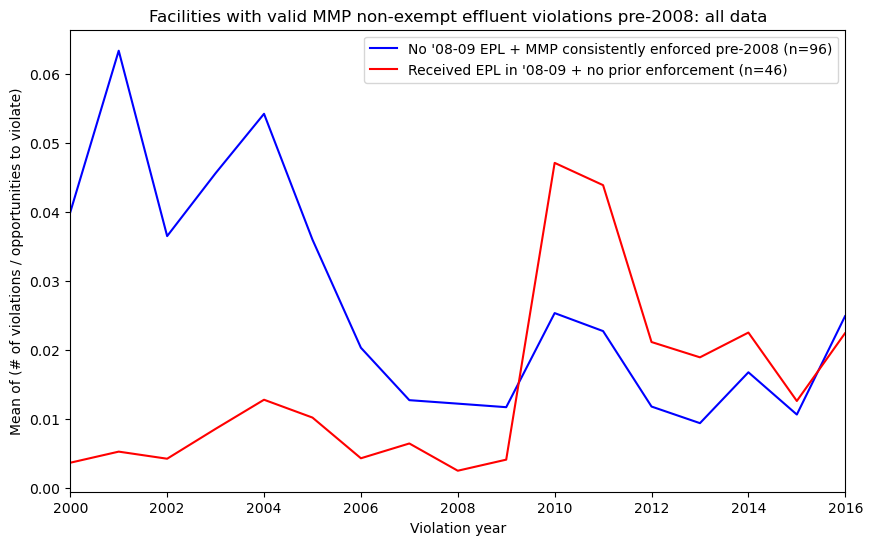

In [52]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(comparison_series['violation_period'],comparison_series['mean_prop_violated'], color='blue', label=f'No \'08-09 EPL + MMP consistently enforced pre-2008 (n={len(comparison_facilities)})')
plt.plot(treatment_series['violation_period'],treatment_series['mean_prop_violated'], color='red', label=f'Received EPL in \'08-09 + no prior enforcement (n={len(treatment_facilities)})')
plt.ylabel('Mean of (# of violations / opportunities to violate)')
plt.xlim((2000, 2016))
plt.xlabel('Violation year')
plt.title('Facilities with valid MMP non-exempt effluent violations pre-2008: all data')
plt.legend();

**Conclusions & key takeaways:**


**So, how do we proceed?**


##### 5. Time series analysis.

First, let's look at all facilities separately.

In [53]:
observed_years = (violations_to_analyze_facility_level['violation_period']).drop_duplicates()

facility_mean_n_violations = pd.DataFrame(observed_years)
facility_mean_n_violations_demeaned = pd.DataFrame(observed_years)

facilities = treatment_facilities

for facility in facilities:
    facility_violations = violations_to_analyze_facility_level[violations_to_analyze_facility_level['FACILITY_ID'] == facility]
    # remove outliers from facility violation count time series (so as not to skew mean)
    '''cutoff = facility_violations['n_violations'].quantile(0.95)
    # if cut-off is 0 but there are non-zero violation counts, take min. # of non-zero violations as cut-off
    if (cutoff == 0) and ((np.max(facility_violations['n_violations'])) != 0):
        cutoff = np.min(facility_violations[facility_violations['n_violations'] > 0]['n_violations'])
    n_violations_mean = np.nanmean(facility_violations['n_violations'].apply(lambda x: x if x < cutoff else np.nan))'''
    n_violations_mean = np.mean(facility_violations['n_violations'])
    # de-mean time series by subtracting mean
    facility_violations['n_violations_demeaned'] = facility_violations['n_violations'] - n_violations_mean
    facility_mean_n_violations = pd.merge(facility_mean_n_violations, facility_violations[['violation_period', 'n_violations']].rename(columns={"n_violations": facility}), how='left').drop_duplicates()
    facility_mean_n_violations_demeaned = pd.merge(facility_mean_n_violations_demeaned, facility_violations[['violation_period', 'n_violations_demeaned']].rename(columns={"n_violations_demeaned": facility}), how='left').drop_duplicates()

facility_mean_n_violations.set_index('violation_period', inplace=True)
facility_mean_n_violations_demeaned.set_index('violation_period', inplace=True)

In [54]:
facility_mean_n_violations

,261701,242338,260400,254691,217317,246710,220809,231891,267571,231379,267428,216832,239497,255833,261343,260494,250161,236061,226200,231239,246614,228856,249957,268611,247207,274044,274103,271217,273772,273575,217352,242342,240791,221225,269042,267130,203650,212135,791884,221224,217790,211482,239498,222132,242279,217321
violation_period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,14.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,24.0,0.0,6.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,2.0
2003,1.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,21.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,5.0
2004,0.0,7.0,0.0,0.0,0.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,0.0,10.0,0.0,8.0,0.0,1.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0
2005,0.0,4.0,0.0,1.0,0.0,3.0,5.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,7.0,0.0,0.0,21.0,1.0,5.0,10.0,0.0,2.0,0.0,4.0,13.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0
2006,1.0,5.0,0.0,12.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0,9.0,2.0,1.0,6.0,0.0,5.0,1.0,2.0,9.0,0.0,3.0,0.0,1.0,13.0,0.0,3.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0
2007,3.0,1.0,0.0,7.0,0.0,0.0,0.0,0.0,3.0,1.0,5.0,0.0,0.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,9.0,0.0,2.0,1.0,11.0,7.0,0.0,0.0,3.0,0.0,16.0,0.0,0.0,0.0,0.0,1.0,1.0,31.0,2.0,1.0,0.0,2.0,0.0,3.0,0.0,0.0
2008,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,5.0,0.0,1.0,1.0,0.0,28.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [55]:
facility_mean_n_violations_demeaned.head()

,261701,242338,260400,254691,217317,246710,220809,231891,267571,231379,267428,216832,239497,255833,261343,260494,250161,236061,226200,231239,246614,228856,249957,268611,247207,274044,274103,271217,273772,273575,217352,242342,240791,221225,269042,267130,203650,212135,791884,221224,217790,211482,239498,222132,242279,217321
violation_period,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000,-0.636364,1.409091,-0.545455,-4.636364,-0.818182,-0.5,-0.818182,-1.318182,-3.272727,-0.590909,-1.181818,-0.272727,2.818182,1.454545,-6.318182,-3.863636,0.545455,-4.545455,-0.136364,-1.181818,-1.318182,-19.363636,2.363636,-0.318182,-1.227273,-7.454545,-0.181818,1.454545,-0.272727,-0.045455,-4.318182,-0.045455,-2.0,-0.272727,0.5,-0.545455,-0.318182,-2.409091,-1.318182,-0.045455,-1.409091,-0.5,-0.045455,-0.227273,-0.318182,-1.363636
2001,-0.636364,-1.590909,-0.545455,-4.636364,-0.818182,-0.5,-0.818182,-1.318182,-3.272727,-0.590909,-1.181818,-0.272727,0.818182,-0.545455,-6.318182,10.136364,-0.454545,-4.545455,-0.136364,-0.181818,-1.318182,-19.363636,-0.636364,-0.318182,-0.227273,-8.454545,-0.181818,2.454545,-0.272727,-0.045455,-5.318182,-0.045455,-1.0,-0.272727,0.5,-0.545455,-0.318182,-1.409091,-1.318182,-0.045455,-1.409091,-0.5,-0.045455,-0.227273,-0.318182,-1.363636
2002,1.363636,-0.590909,0.454545,-4.636364,-0.818182,-0.5,-0.818182,-1.318182,-1.272727,2.409091,-0.181818,-0.272727,-0.181818,-0.545455,-6.318182,20.136364,-0.454545,0.454545,-0.136364,-2.181818,-1.318182,-19.363636,1.363636,-0.318182,-0.227273,-9.454545,-0.181818,-0.545455,-0.272727,-0.045455,-4.318182,-0.045455,0.0,-0.272727,1.5,-0.545455,-0.318182,-2.409091,-1.318182,-0.045455,5.590909,-0.5,-0.045455,-0.227273,-0.318182,0.636364
2003,0.363636,2.409091,-0.545455,-4.636364,-0.818182,-0.5,0.181818,0.681818,-3.272727,0.409091,-0.181818,-0.272727,-0.181818,-0.545455,-6.318182,17.136364,1.545455,1.454545,-0.136364,-2.181818,-1.318182,-19.363636,-0.636364,-0.318182,0.772727,-8.454545,-0.181818,0.454545,-0.272727,-0.045455,-4.318182,-0.045455,3.0,-0.272727,1.5,-0.545455,-0.318182,-2.409091,-1.318182,-0.045455,19.590909,-0.5,-0.045455,-0.227273,-0.318182,3.636364
2004,-0.636364,5.409091,-0.545455,-4.636364,-0.818182,7.5,0.181818,-0.318182,-2.272727,-0.590909,-1.181818,-0.272727,-0.181818,0.454545,1.681818,-1.863636,-0.454545,4.454545,-0.136364,5.818182,-1.318182,-18.363636,-0.636364,-0.318182,1.772727,-9.454545,-0.181818,-0.545455,-0.272727,-0.045455,-5.318182,-0.045455,-1.0,-0.272727,1.5,-0.545455,-0.318182,-2.409091,-1.318182,-0.045455,-1.409091,1.5,-0.045455,-0.227273,-0.318182,2.636364


<Figure size 1000x600 with 0 Axes>

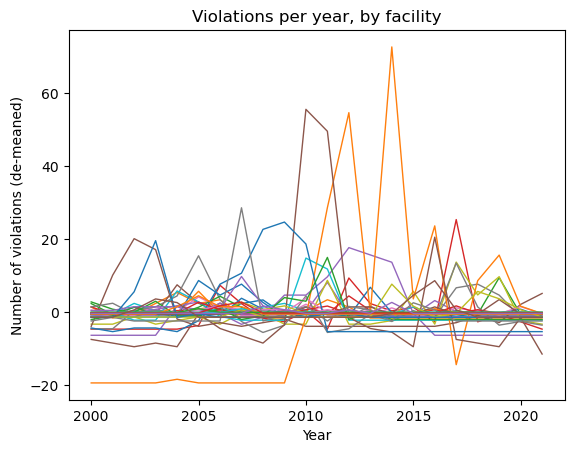

In [56]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
facility_mean_n_violations_demeaned.plot(linewidth=1, legend=False)
#plt.ylim(-5, 5)
plt.title('Violations per year, by facility')
plt.xlabel('Year')
plt.ylabel('Number of violations (de-meaned)');

Now, let's look at the mean across facilities.

In [57]:
use_demeaned = True

all_facilities_mean_n_violations = pd.DataFrame(index=facility_mean_n_violations.index)
all_facilities_mean_n_violations['mean_n_violations_mean'] = np.nan
all_facilities_mean_n_violations['mean_n_violations_sem'] = np.nan

for year in observed_years:
    if use_demeaned == True:
        mean_n_violations_by_facility = facility_mean_n_violations_demeaned.loc[[year]]
    else:
        mean_n_violations_by_facility = facility_mean_n_violations.loc[[year]]
    # remove outlier violation counts when considering all facilities' counts in a given year
    lower_cutoff = mean_n_violations_by_facility.quantile(0.00, axis=1)
    #upper_cutoff = mean_n_violations_by_facility.quantile(0.95, axis=1)
    upper_cutoff = mean_n_violations_by_facility.quantile(1.0, axis=1)
    mean_n_violations_mean = np.nanmean(mean_n_violations_by_facility[(mean_n_violations_by_facility > lower_cutoff.iloc[0]) &
                                                                      (mean_n_violations_by_facility < upper_cutoff.iloc[0])])
    mean_n_violations_no_outliers = mean_n_violations_by_facility[(mean_n_violations_by_facility > lower_cutoff.iloc[0]) &
                                                                  (mean_n_violations_by_facility < upper_cutoff.iloc[0])]
    mean_n_violations_sem = scipy.stats.sem(mean_n_violations_no_outliers, nan_policy='omit', axis=1)[0]
    all_facilities_mean_n_violations.loc[[year]] = [mean_n_violations_mean, mean_n_violations_sem]

all_facilities_mean_n_violations.head()

,mean_n_violations_mean,mean_n_violations_sem
violation_period,,
2000,-1.110537,0.297102
2001,-1.140496,0.293565
2002,-0.663223,0.337402
2003,-0.173554,0.518258
2004,-0.330579,0.371396


In [58]:
all_facilities_mean_n_violations['mean_n_violations_lower_bound'] = all_facilities_mean_n_violations['mean_n_violations_mean'] - 1.96*all_facilities_mean_n_violations['mean_n_violations_sem']
all_facilities_mean_n_violations['mean_n_violations_upper_bound'] = all_facilities_mean_n_violations['mean_n_violations_mean'] + 1.96*all_facilities_mean_n_violations['mean_n_violations_sem']
all_facilities_mean_n_violations.head()

,mean_n_violations_mean,mean_n_violations_sem,mean_n_violations_lower_bound,mean_n_violations_upper_bound
violation_period,,,,
2000,-1.110537,0.297102,-1.692857,-0.528218
2001,-1.140496,0.293565,-1.715883,-0.565109
2002,-0.663223,0.337402,-1.324531,-0.001915
2003,-0.173554,0.518258,-1.189339,0.842232
2004,-0.330579,0.371396,-1.058514,0.397357


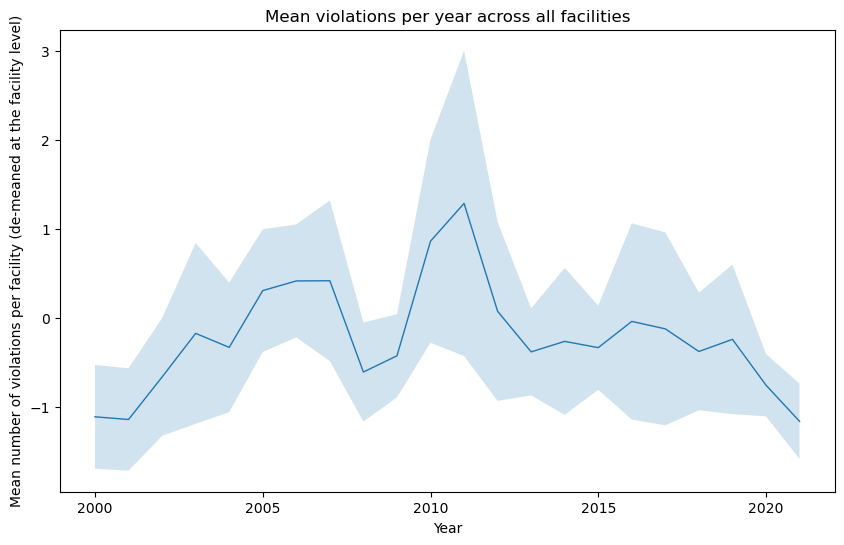

In [59]:
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.title('Mean violations per year across all facilities')
plt.xlabel('Year')
if use_demeaned == True:
    plt.ylabel('Mean number of violations per facility (de-meaned at the facility level)')
else:
    plt.ylabel('Mean number of violations')
plt.plot(all_facilities_mean_n_violations.index, all_facilities_mean_n_violations['mean_n_violations_mean'], linewidth=1)
plt.fill_between(x=all_facilities_mean_n_violations.index,
                 y1=all_facilities_mean_n_violations['mean_n_violations_lower_bound'],
                 y2=all_facilities_mean_n_violations['mean_n_violations_upper_bound'],
                 alpha=0.2);